<a href="https://colab.research.google.com/github/Malikshemi3344/datascienceproject/blob/main/datascience_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import necessary libraries**

In [1]:
import numpy as np  # For numerical computations and handling arrays
import pandas as pd  # For data manipulation and analysis

# For creating and plotting the correlation matrix
import matplotlib.pyplot as plt  # For creating static, interactive, and animated visualizations
from matplotlib import gridspec  # For creating complex grid layouts for plots

import kagglehub  # For downloading datasets from Kaggle

from imblearn.over_sampling import SMOTE  # For handling imbalanced datasets by oversampling the minority class
from sklearn.model_selection import train_test_split  # For splitting datasets into training and testing sets
from sklearn.linear_model import LogisticRegression  # For applying logistic regression models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc  # For evaluating model performance
from sklearn.preprocessing import StandardScaler  # For standardizing features by scaling them
from sklearn.metrics import precision_recall_curve  # For plotting precision-recall curves
from sklearn.metrics import precision_score, recall_score, f1_score  # For calculating precision, recall, and F1 score
from sklearn.calibration import calibration_curve  # For assessing how well predicted probabilities match actual outcomes
import joblib  # For saving and loading models to/from disk
from sklearn.ensemble import RandomForestClassifier  # For creating ensemble models using random forests
from sklearn.model_selection import learning_curve  # For evaluating model performance over different training set sizes
import seaborn as sns  # For creating attractive and informative statistical graphics

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

## **Loading the data and understanding it**

In [2]:
#download the dataset and import the csv file using pandas
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
data_frame = pd.read_csv(f"{path}/creditcard.csv")
#print some data to analyze
print(data_frame.head)

100%|██████████| 66.0M/66.0M [00:00<00:00, 77.4MB/s]

Extracting files...


<bound method NDFrame.head of             Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.

# **Display the data frame shape and information**
Display the shape

Information

Description

In [ ]:
#print data frame
data_frame.shape

(284807, 31)

In [ ]:
#print dataframe info
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
data_frame.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


# **Check for any missing values**

In [ ]:
# Cheking percent of missing values in columns
df_missing_columns = (round(((data_frame.isnull().sum()/len(data_frame.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
df_missing_columns

,null
Time,0.0
V16,0.0
Amount,0.0
V28,0.0
V27,0.0
V26,0.0
V25,0.0
V24,0.0
V23,0.0
V22,0.0


# **Analyze the class distribution**

In [ ]:
classes = data_frame['Class'].value_counts()
classes

,count
Class,
0,284315
1,492


In [ ]:
valid_transactions_share =round((classes[0]/data_frame['Class'].count()*100),2)
valid_transactions_share

99.83

In [ ]:
fraud_transactions_share = round((classes[1]/data_frame['Class'].count()*100),2)
fraud_transactions_share

0.17

In [ ]:
# Creating dataframe for fraudulent transactions
fraudulent_transactions= data_frame[data_frame['Class'] == 1]

# Creating dataframe for non-fraudulent transactions
valid_transactions= data_frame[data_frame['Class'] == 0]


In [ ]:
import pandas as pd

# Load the dataset (assuming it's already downloaded)

# Check for negative time values
negative_time = data_frame[data_frame['Time'] < 0]

# Print result
if negative_time.empty:
    print("No negative time values exist.")
else:
    print(negative_time)


No negative time values exist.


# **Analyze the time distribution**

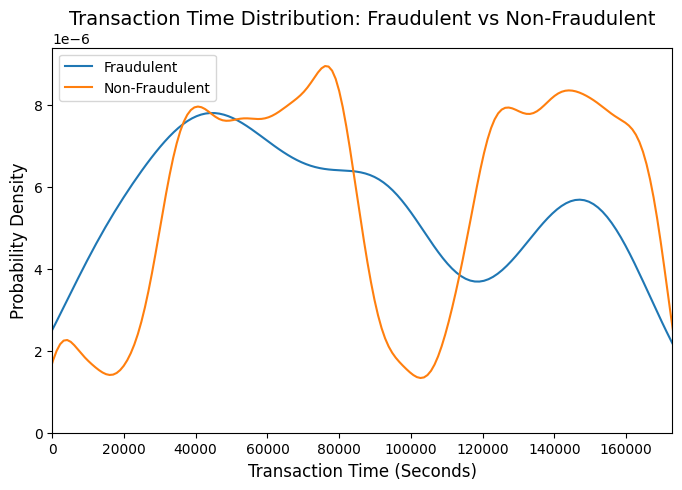

In [ ]:
# Distribution plot
plt.figure(figsize=(8, 5))

# Plot for fraudulent transactions
sns.kdeplot(data=fraudulent_transactions['Time'], label='Fraudulent', fill=False)

# Plot for non-fraudulent transactions
sns.kdeplot(data=valid_transactions['Time'], label='Non-Fraudulent', fill=False)


plt.xlim(0, max(fraudulent_transactions['Time'].max(), valid_transactions['Time'].max()))

# Adding labels and title
plt.xlabel('Transaction Time (Seconds)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.title('Transaction Time Distribution: Fraudulent vs Non-Fraudulent', fontsize=14)
plt.legend()

# Display the plot
plt.show()


# **Analyze the transaction amounts**

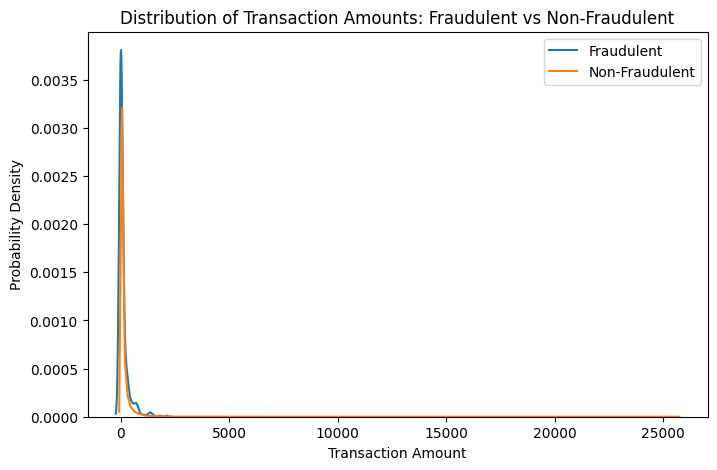

In [ ]:
# Distribution plot
plt.figure(figsize=(8, 5))

# Plot for fraudulent transaction amounts
fraudulent_amount_plot = sns.kdeplot(data=fraudulent_transactions['Amount'], label='Fraudulent', fill=False)

# Plot for non-fraudulent transaction amounts
non_fraudulent_amount_plot = sns.kdeplot(data=valid_transactions['Amount'], label='Non-Fraudulent', fill=False)

# Adding labels and title
fraudulent_amount_plot.set(xlabel='Transaction Amount', ylabel='Probability Density')
plt.title('Distribution of Transaction Amounts: Fraudulent vs Non-Fraudulent')
plt.legend()

# Display the plot
plt.show()

# **Compute the correlation matrix**

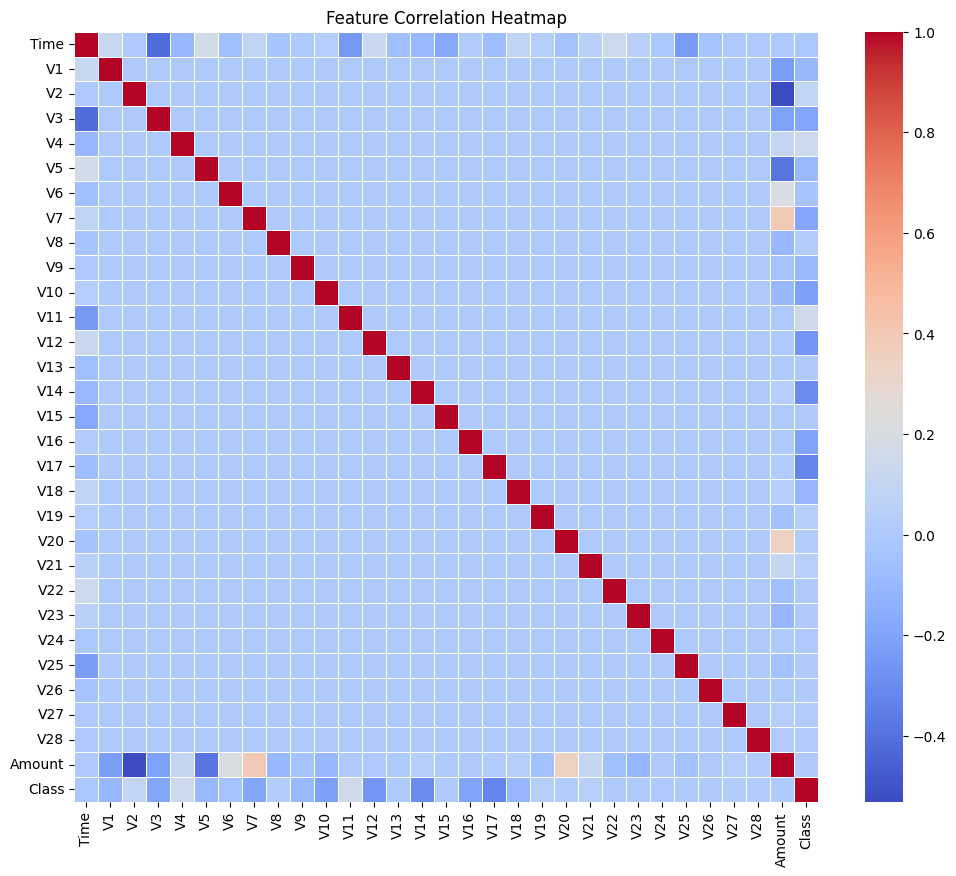

In [ ]:
# Compute the correlation matrix
# This captures the pairwise relationships between numerical features in the dataset
corr_matrix = data_frame.corr()

# Step 4: Visualize the correlation matrix as a heatmap
# The heatmap provides an intuitive view of the strength and direction of correlations
plt.figure(figsize=(12, 10))  # Set the figure size for better readability
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)  # Create heatmap
plt.title("Feature Correlation Heatmap")  # Add a descriptive title
plt.show()

# **Split into testing and training samples**

In [ ]:
# Separate features and target/labels
X = data_frame.drop(columns=['Class'])
y = data_frame['Class']

# Split data into training and testing sets using the sklearn library
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Length of training smaples:',len(X_train))
print('Length of testing smaples:',len(X_test))

Length of training smaples: 227845
Length of testing smaples: 56962


In [ ]:
# Listing the columns
all_columns = X_train.columns
all_columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

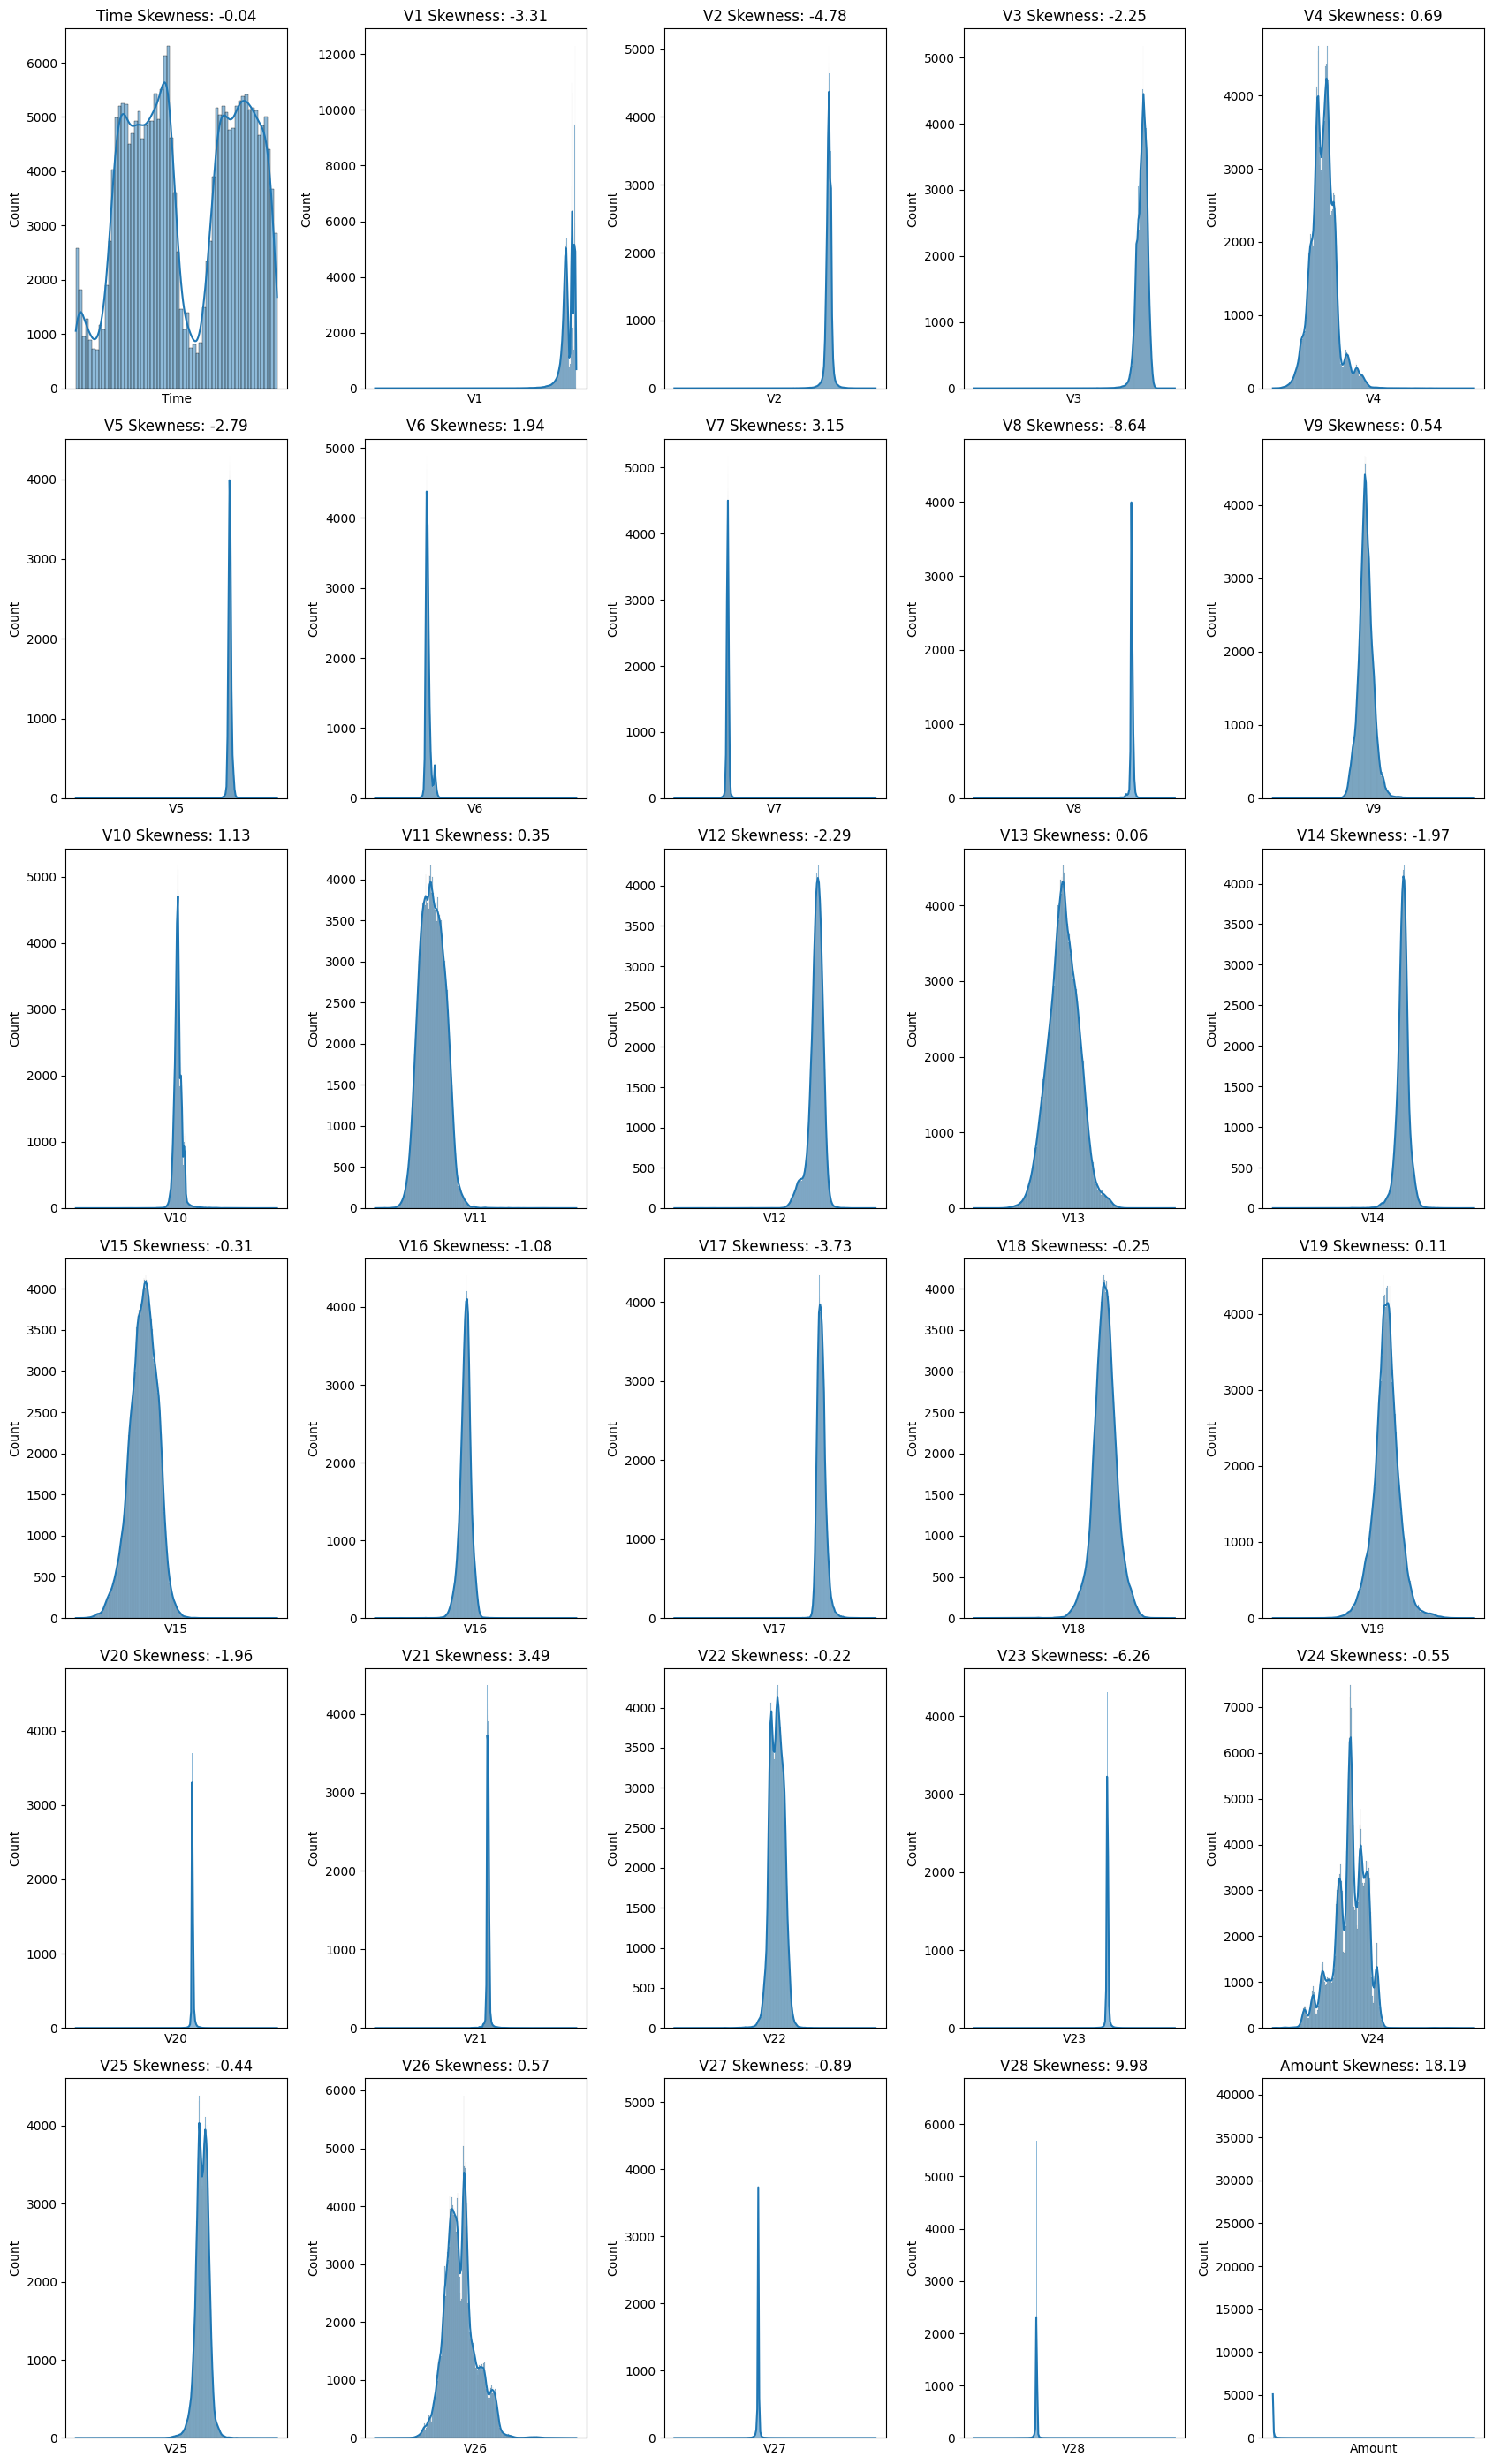

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_counter = 0
plt.figure(figsize=(17, 28))

for column in all_columns:
    plot_counter += 1
    plt.subplot(6, 5, plot_counter)
    sns.histplot(X_train[column], kde=True)
    plt.title(f"{column} Skewness: {X_train[column].skew():.2f}")

    # Remove x-axis labels and ticks
    plt.xticks([])

plt.tight_layout()  # To avoid overlapping of subplots
plt.show()


# **Make up for class imbalance using SMOTE**
**Synthetic Minority Oversampling Technique is used to create new samples for any particular class**

**Here we will use it to create more fraudulent transaction samples**

In [ ]:
# Initial resampling using SMOTE
desired_samples_class_1 = 90000

# Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy={1: desired_samples_class_1}, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the number of samples
print("Original training samples:", len(X_train))
print("Synthetic samples generated for class 1:", len(X_train_smote)-len(X_train))
print("Total samples in combined training dataset:", len(X_train_smote))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Original training samples: 227845
Synthetic samples generated for class 1: 89606
Total samples in combined training dataset: 317451


# **Apply Scaling Before Logistic Regression**

In [ ]:
# Scaling the data
# Logistic regression is sensitive to feature scales, so we use StandardScaler to standardize the data
# StandardScaler scales the data so that each feature has a mean of 0 and a standard deviation of 1
scaler = StandardScaler()

# Fit the scaler on the training data and transform it to make the data standardized
X_train_smote_scaled = scaler.fit_transform(X_train_smote)

# Use the same scaler (already fit on the training data) to transform the test data.
# This ensures that the test data is scaled using the same scaling factors as the training data.
X_test_scaled = scaler.transform(X_test)

# Convert the scaled training data to a DataFrame for display
X_train_scaled_df = pd.DataFrame(X_train_smote_scaled, columns=X_train_smote.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Display the first few rows of the scaled training data
print("Scaled Training Data:")
print(X_train_scaled_df.head())

# Display the first few rows of the scaled test data
print("\nScaled Test Data:")
print(X_test_scaled_df.head())

Scaled Training Data:
       Time        V1        V2        V3        V4        V5        V6  \
0  1.469387  0.743883 -0.592833  0.139241 -0.707863  0.724083  2.802601   
1  0.688433  0.763657 -0.363237 -0.194550 -0.383609  1.155515  2.343330   
2 -1.048719  0.086572 -0.150468  0.544264 -0.825788  0.026726  1.494374   
3  0.858361  0.819703 -0.836810  0.258286 -1.066667 -0.143463  0.035681   
4 -0.669777  0.208067 -0.677316  0.427471 -1.703620  0.488387  0.163963   

         V7        V8        V9  ...       V20       V21       V22       V23  \
0  0.033928  0.263987  1.118698  ... -0.254227 -0.055741  0.303476  0.366535   
1  0.356557  0.133226  0.413391  ... -0.354051 -0.074939  0.229846  0.054757   
2 -0.126122 -1.472767  0.390042  ...  1.267461 -1.524700  0.103831 -0.485614   
3  0.045212 -0.053672 -0.189970  ... -0.637212 -0.166054  0.069306  0.252520   
4  0.467168 -0.088486  0.366435  ... -0.405678 -0.218983 -0.196495  0.006411   

        V24       V25       V26       V27     

# **Hyper Parameter Tuning**

In [ ]:
# Creating KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=4)

# Specify parameter values
params = {"C": [0.01, 0.1, 1, 10, 100, 1000,10000]}

#Setting the scoring metric to recall
logistic_regression_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params,
                        scoring= 'roc_auc',
                        cv = folds,
                        verbose = 1,
                        return_train_score=True)

logistic_regression_cv.fit(X_train_smote_scaled, y_train_smote)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [ ]:
#the results
cv_results = pd.DataFrame(logistic_regression_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.805608,0.317102,0.049462,0.016870,0.01,{'C': 0.01},0.996748,0.997116,0.996835,0.996697,...,0.996856,0.000145,6,0.996889,0.996804,0.996873,0.996904,0.996863,0.996866,0.000034
1,1.371511,0.236782,0.054497,0.019095,0.10,{'C': 0.1},0.997357,0.997593,0.997323,0.997270,...,0.997390,0.000111,5,0.997407,0.997340,0.997415,0.997451,0.997395,0.997402,0.000036
2,1.989955,0.633010,0.105503,0.047799,1.00,{'C': 1},0.997517,0.997695,0.997418,0.997405,...,0.997510,0.000103,4,0.997518,0.997467,0.997527,0.997583,0.997510,0.997521,0.000037
3,2.033817,0.428044,0.088291,0.027290,10.00,{'C': 10},0.997534,0.997713,0.997426,0.997418,...,0.997525,0.000106,3,0.997528,0.997484,0.997538,0.997596,0.997528,0.997535,0.000036
4,1.684890,0.383285,0.060671,0.013249,100.00,{'C': 100},0.997540,0.997714,0.997428,0.997425,...,0.997528,0.000105,2,0.997533,0.997486,0.997540,0.997607,0.997530,0.997539,0.000039
5,1.265915,0.325795,0.046320,0.012879,1000.00,{'C': 1000},0.997540,0.997714,0.997428,0.997545,...,0.997552,0.000092,1,0.997533,0.997486,0.997541,0.997710,0.997530,0.997560,0.000077


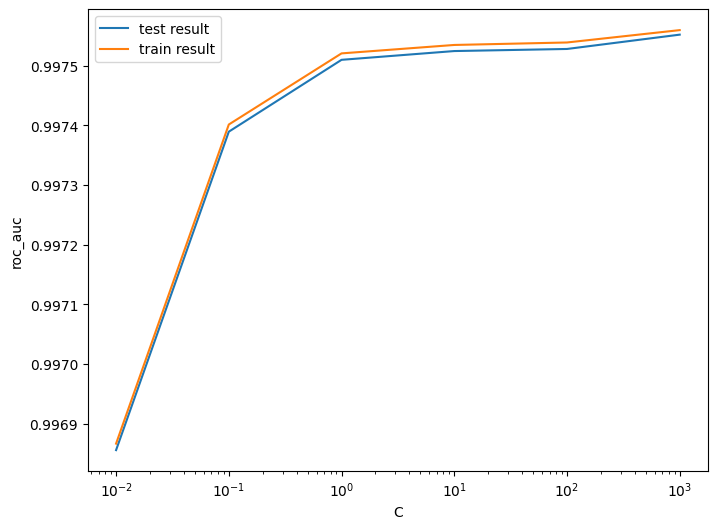

In [ ]:
# plot of C versus train and validation scores
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('roc_auc')
plt.legend(['test result', 'train result'], loc='upper left')
plt.xscale('log')

In [ ]:
# Best score with best C
best_score =logistic_regression_cv.best_score_
best_C = logistic_regression_cv.best_params_['C']

print(" The highest test roc_auc is {0} at C = {1}".format(best_score, best_C))

 The highest test roc_auc is 0.997552221562738 at C = 1000


# **LOGISTIC REGRESSION**

In [ ]:
#Initialize the Logistic Regression model
# Here, we are specifying:
# `max_iter=5000`: Allow the model to run up to 5000 iterations (the model is having trouble converging with less iterations than this)
# solver='saga'`: This is an optimization algorithm, particularly good for large datasets or sparse data(so that the model converges with ease)
# `random_state=42`: Ensures reproducibility of results
log_reg = LogisticRegression(max_iter=5000, solver='saga', random_state=42,C=1000)

#Train the Logistic Regression model
# .fit() method trains the model using the scaled training data (X_train_smote_scaled)
history=log_reg.fit(X_train_smote_scaled, y_train_smote)

# Make predictions on the test data
y_pred = log_reg.predict(X_test_scaled)

# .predict_proba() method gives probabilities for each class (0 or 1).
# We're taking probabilities for the positive class (fraudulent transactions) with [:, 1]
y_pred_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

print('done')


done


# **Plot confusion matrix**


 ===Confusion Matrix ===
[[56578   286]
 [   11    87]]


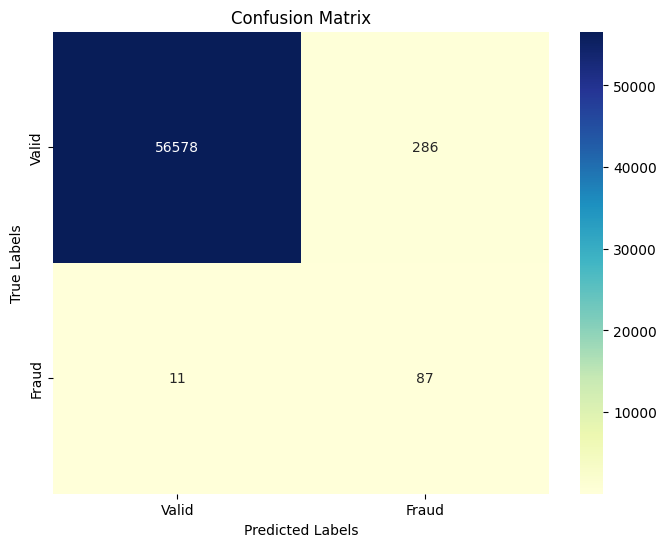

In [ ]:
# Confusion Matrix
# The confusion matrix helps us evaluate the performance of our model by showing the count of the following
# True Positive (TP): correctly predicted fraud cases, True Negative (TN): correctly predicted valid transactions
# False Positive (FP): incorrectly predicted fraud cases (valid transactions predicted as fraud), False Negative (FN): incorrectly predicted valid transactions (fraud cases predicted as valid)
conf_matrix = confusion_matrix(y_test, y_pred)

# Printing the confusion matrix
print("\n ===Confusion Matrix ===")
print(conf_matrix)

# Visualizing the Confusion Matrix
# using a heatmap for  a better visual representation
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu", xticklabels=['Valid', 'Fraud'], yticklabels=['Valid', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# **Analyze Class Report**

In [ ]:
# The classification report provides a detailed evaluation of the model
# Precision: The percentage of correctly predicted fraud cases
# Recall: The percentage of correctly predicted fraud instances among all actual fraud cases
# F1-score: The harmonic mean of precision and recall
#  Support: The number of actual instances of each class in the dataset
class_report = classification_report(y_test, y_pred)
print("\n=== Classification Report ===")
print(class_report)


=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.23      0.89      0.37        98

    accuracy                           0.99     56962
   macro avg       0.62      0.94      0.68     56962
weighted avg       1.00      0.99      1.00     56962



# **Calculate Accuracy**

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 99.48%


# **Receiver Operating Curve**

In [ ]:
# Calculate ROC AUC Score
roc_auc = roc_auc_score(y_test,y_pred_prob)

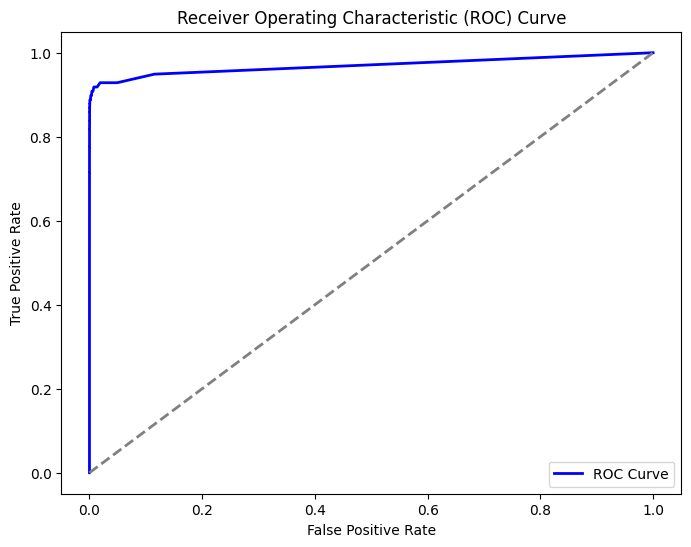

ROC AUC Score: 0.9695355298140641


In [ ]:
from sklearn.metrics import roc_curve

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test,y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2,label="ROC Curve")
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print AUC
print("ROC AUC Score:", roc_auc)


# **Precision Recall Curve**

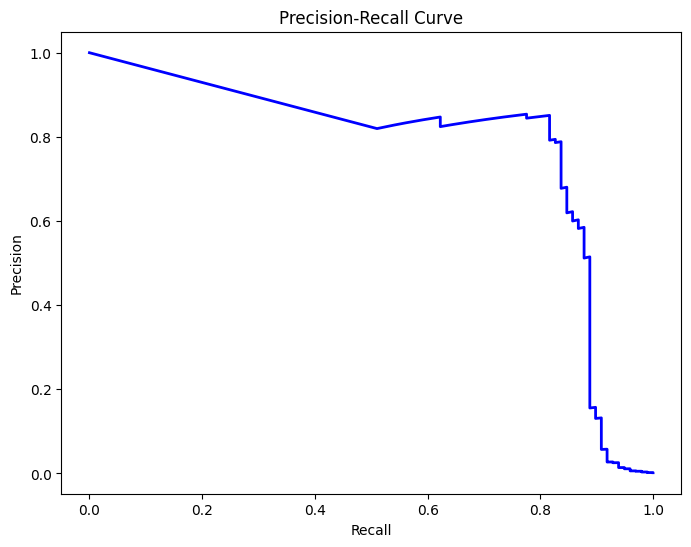

In [ ]:
# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

# **Plot Model Metrics**
**Precision**

**Recall**

**F1 Score**

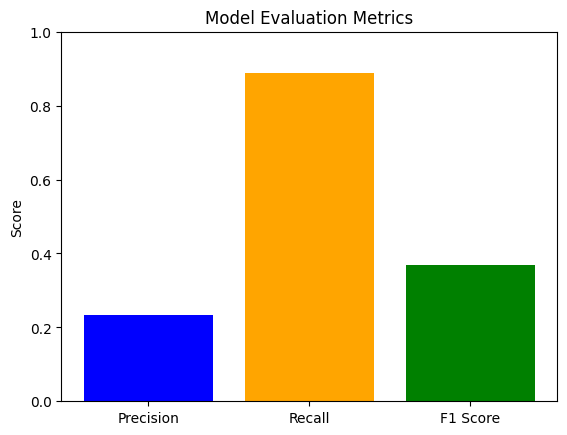

In [ ]:
# Compute metrics at a particular threshold
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

metrics = [precision, recall, f1]
metric_names = ['Precision', 'Recall', 'F1 Score']

plt.bar(metric_names, metrics, color=['blue', 'orange', 'green'])
plt.title("Model Evaluation Metrics")
plt.ylabel("Score")
plt.ylim([0, 1])
plt.show()

### **Random Forest**

### **Hyperparameter Tuning with GridSearchCV**

In [ ]:
param_grid = {
    'max_depth': range(5,10,5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'n_estimators': [100,200,300],
    'max_features': [10, 20]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf,
                           param_grid = param_grid,
                           cv = 2,
                           n_jobs = -1,
                           verbose = 1,
                           return_train_score=True)

# Fit the model
grid_search.fit(X_train_smote, y_train_smote)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


In [ ]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.85 using {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 200, 'max_features': 10}


# **Training the model with optimal params**


In [ ]:
# Import necessary libraries
import joblib  # For saving the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the Random Forest Classifier
random_forest_model = RandomForestClassifier(bootstrap=True,
                             max_depth=10,
                             min_samples_leaf=50,
                             min_samples_split=100,
                             max_features=10,
                             n_estimators=200)

# Fit the model on the training data
history_rf=random_forest_model.fit(X_train_smote, y_train_smote)

# Save the model to a file
joblib.dump(random_forest_model, 'random_forest_model.pkl')
print("Random Forest model saved as 'random_forest_model.pkl'.")


Random Forest model saved as 'random_forest_model.pkl'.


# **Analyze Class Report**

In [ ]:
# Make predictions
y_predicted_random_forest = random_forest_model.predict(X_test)

# Evaluate the Random Forest model
print("Random Forest Classifier Performance:")
print("Accuracy Score:", accuracy_score(y_test, y_predicted_random_forest))
print("Classification Report:\n", classification_report(y_test, y_predicted_random_forest))


Random Forest Classifier Performance:
Accuracy Score: 0.9995084442259752
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.87      0.86        98

    accuracy                           1.00     56962
   macro avg       0.92      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962



# **Condusion Matrix**

Confusion Matrix:
 [[56849    15]
 [   13    85]]


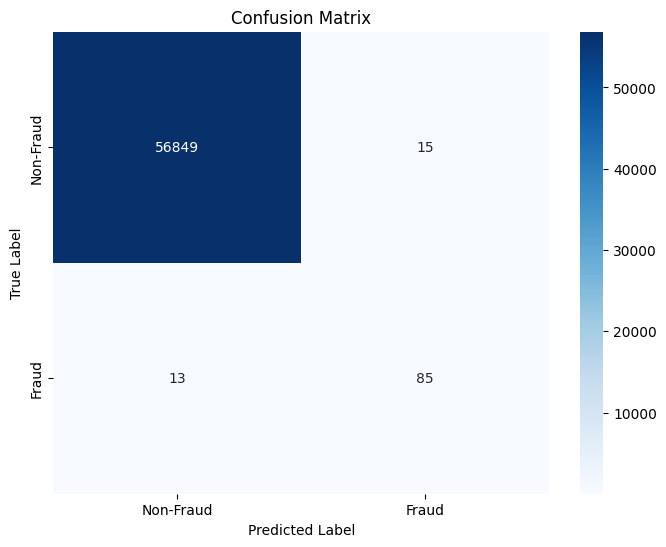

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_predicted_random_forest)
print("Confusion Matrix:\n", conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_predicted_random_forest)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 99.54%


# **Receiver Operating Curve**

In [ ]:
# Calculate ROC AUC Score
roc_auc_rf = roc_auc_score(y_test,y_predicted_random_forest.predict_proba(X_test)[:, 1])

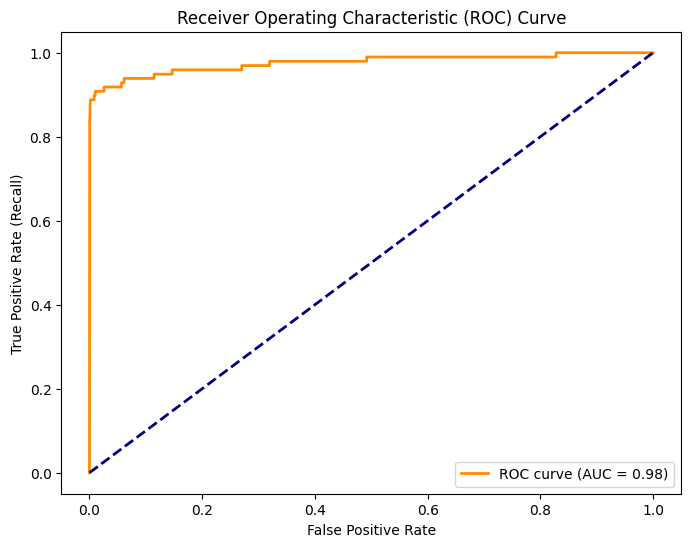

In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)  # y_pred_prob is the predicted probabilities
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="lower right")
plt.show()

# **Precision Recall Curve**

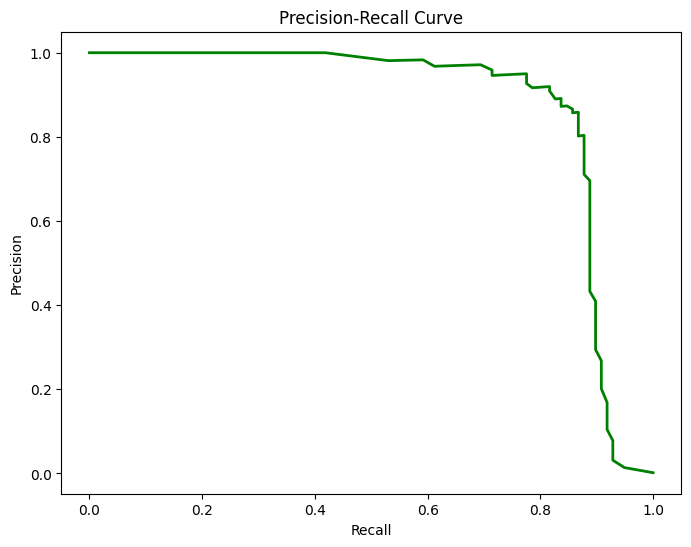

Average Precision Score: 0.872534946586448


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, random_forest_model.predict_proba(X_test)[:, 1])

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Average Precision Score
print("Average Precision Score:", average_precision_score(y_test, random_forest_model.predict_proba(X_test)[:, 1]))


# **Analyze Feature Importance**

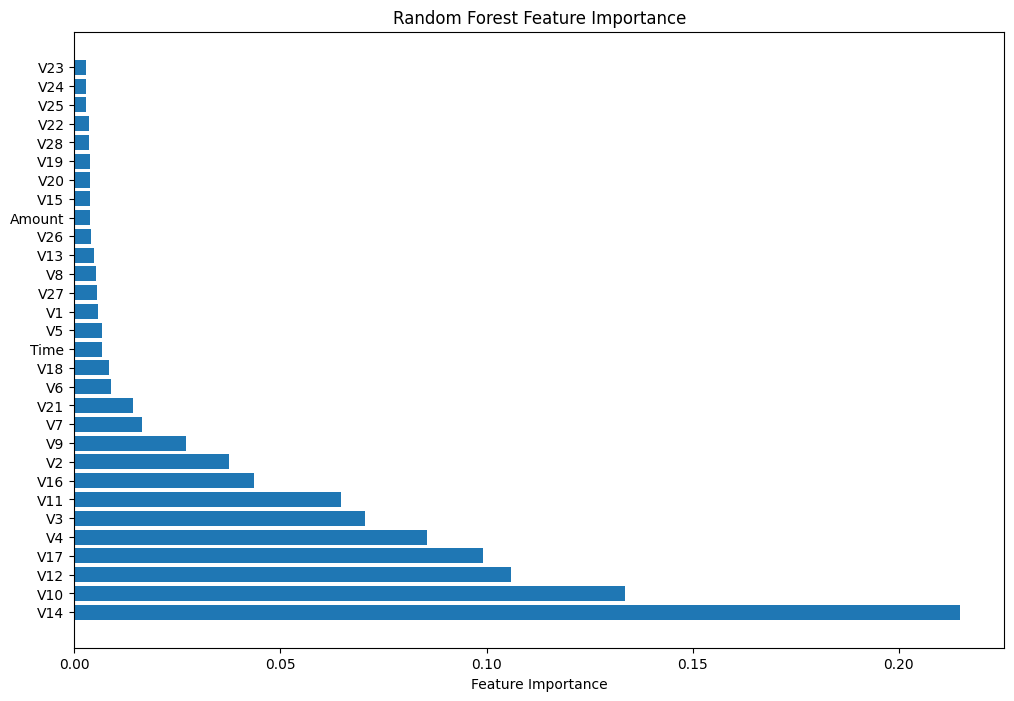

In [ ]:
# Get feature importances
feature_importances = random_forest_model.feature_importances_

# Sort feature importances in descending order
indices = feature_importances.argsort()[::-1]

# Plot Feature Importance
plt.figure(figsize=(12, 8))
plt.barh(range(X_train_smote.shape[1]), feature_importances[indices], align="center")
plt.yticks(range(X_train_smote.shape[1]), X_train.columns[indices])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()


# **XG Boost**

# **Tuning Hyperparams**

In [ ]:
# hyperparameter tuning with XGBoost

# creating a KFold object
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6],
             'subsample': [0.3, 0.6, 0.9]}


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model,
                        param_grid = param_grid,
                        scoring= 'roc_auc',
                        cv = folds,
                        verbose = 1,
                        return_train_score=True)

# fit the model
model_cv.fit(X_train_smote, y_train_smote)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [ ]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results
model_cv.best_params_

# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for calculating auc
params = {'learning_rate': 0.2,
          'max_depth': 2,
          'n_estimators':200,
          'subsample':0.9,
         'objective':'binary:logistic'}

# fit model on training data
xgb_imb_model = XGBClassifier(params = params)
xgb_imb_model.fit(X_train_smote, y_train_smote)

# Predictions on the train set
y_train_pred = xgb_imb_model.predict(X_train_smote)



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:56:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "params" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Predictions on the test set
y_test_pred = model_cv.best_estimator_.predict(X_test)
y_test_proba = model_cv.best_estimator_.predict_proba(X_test)[:, 1]  # Probability for ROC AUC


# **Confusion Matrix**

Confusion Matrix:
[[56819    45]
 [   14    84]]


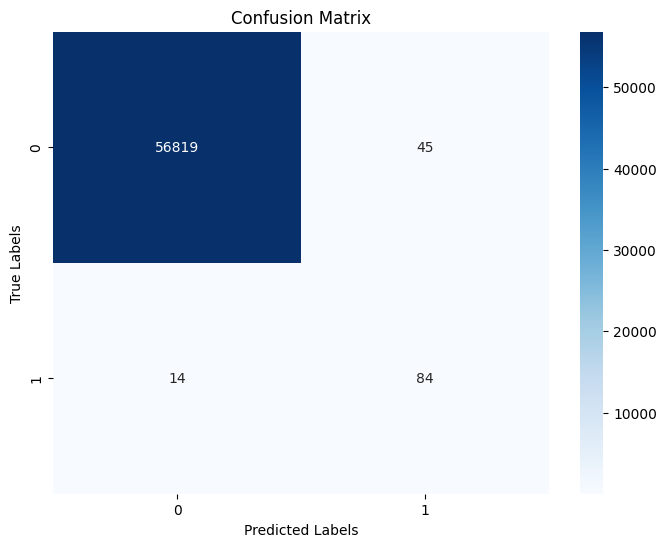

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# **Classification Report**

In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.65      0.86      0.74        98

    accuracy                           1.00     56962
   macro avg       0.83      0.93      0.87     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 99.47%


In [ ]:
# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_test_proba)
print("ROC AUC Score:", roc_auc)


ROC AUC Score: 0.9743304468664225


# **ROC Curve**

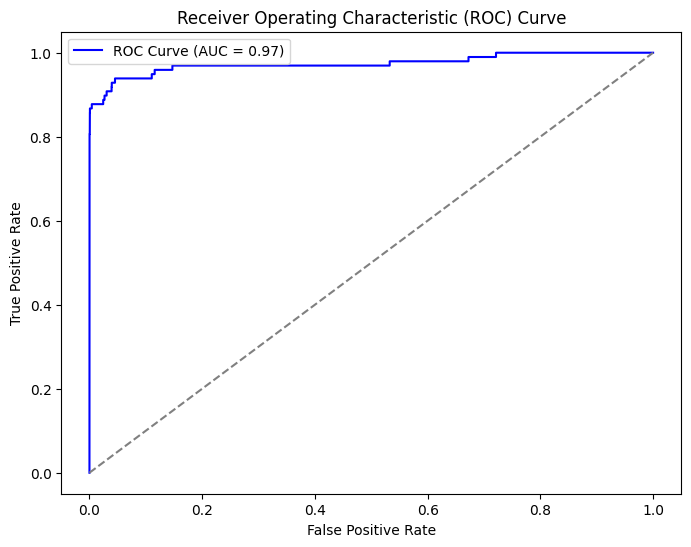

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

In [ ]:
# Feature Importance Plot
feature_importance = model_cv.best_estimator_.feature_importances_
sorted_idx = feature_importance.argsort()

# **Analyze Feature Importance**

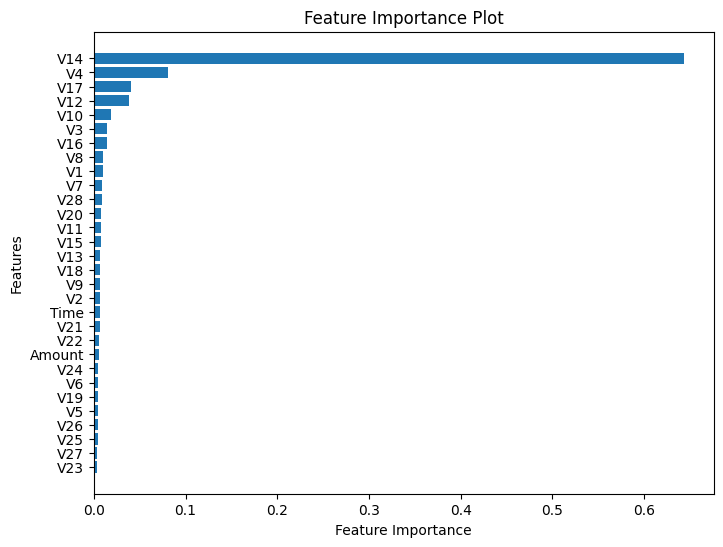

In [ ]:
plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X_train.columns[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance Plot")
plt.show()


In [ ]:
# Save model for future use
import joblib
joblib.dump(model_cv.best_estimator_, "xgboost_model.pkl")
print("Model saved as xgboost_model.pkl")

Model saved as xgboost_model.pkl


# **Precision Recall Curve**

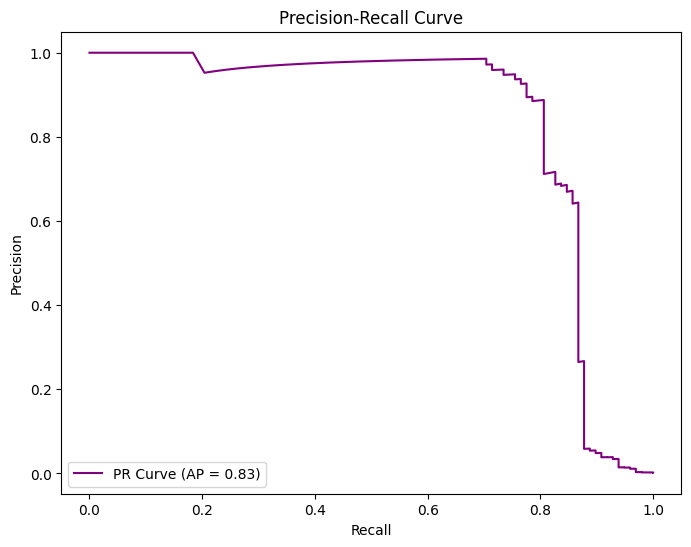

Average Precision Score (AP): 0.8342415925581274


In [ ]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_test_proba)
avg_precision = average_precision_score(y_test, y_test_proba)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', label=f"PR Curve (AP = {avg_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Print Average Precision Score
print("Average Precision Score (AP):", avg_precision)

# **Multilayer Perceptron MLP**
**Hyper-paramter tuning using grid search**

In [ ]:
from sklearn.neural_network import MLPClassifier
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)
# Define the parameter grid for MLPClassifier
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (100, 50), (150, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}
mlp = MLPClassifier(max_iter=300, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=mlp,
                           param_grid=param_grid,
                           cv=3,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=2,
                           return_train_score=True)

# Fit the model with GridSearchCV
grid_search.fit(X_train_scaled, y_train_smote)

Fitting 3 folds for each of 72 candidates, totalling 216 fits

Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (150,), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [ ]:
# Initialize MLPClassifier with the best parameters
mlp = MLPClassifier(
    hidden_layer_sizes=(150,),  # based on best parameters
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    alpha=0.001,
    max_iter=10000,             # Large number of iterations to ensure convergence
    random_state=42             # For reproducibility
)

# Train the model
mlp.fit(X_train_scaled, y_train_smote)

# Make predictions
y_pred = mlp.predict(X_test_scaled)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9992802219023208
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.77      0.83      0.80        98

    accuracy                           1.00     56962
   macro avg       0.89      0.91      0.90     56962
weighted avg       1.00      1.00      1.00     56962



# **Confusion Matrix**

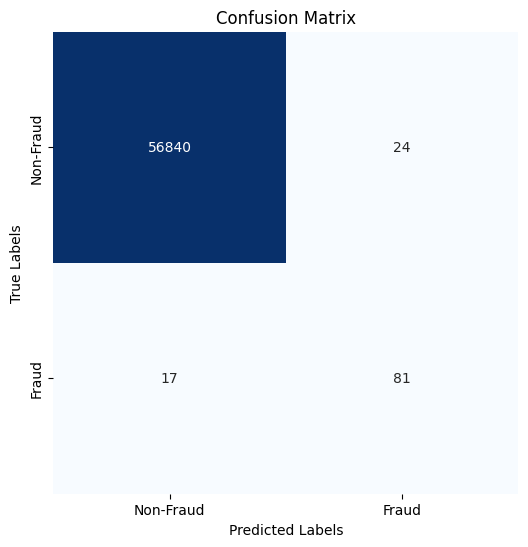

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


# **ROC Curve**

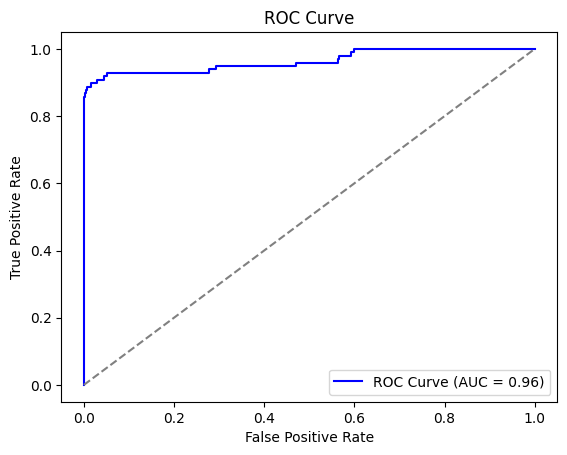

In [ ]:
# ROC Curve
y_pred_prob = mlp.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 99.50%


# **Precision-Recall Curve**

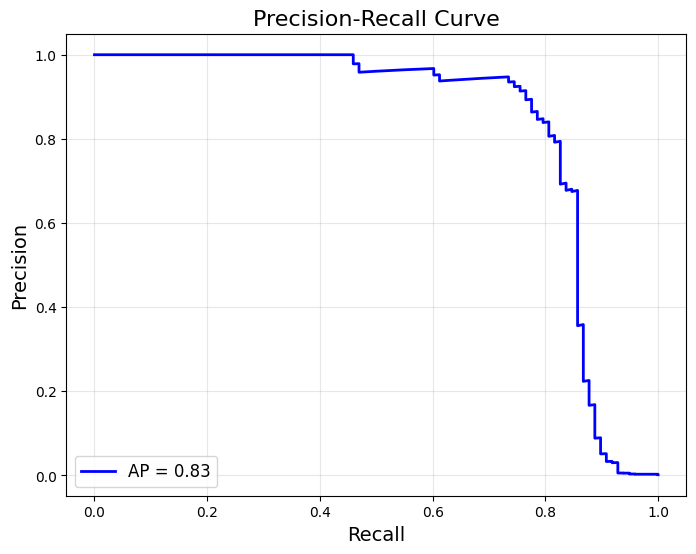

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, mlp.predict_proba(X_test_scaled)[:, 1])

# Calculate Average Precision Score
avg_precision = average_precision_score(y_test, mlp.predict_proba(X_test_scaled)[:, 1])

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}', color='blue', linewidth=2)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc='lower left', fontsize=12)
plt.grid(alpha=0.3)
plt.show()
